In [1]:
#%% Add to path
import sys
%cd /media/theodore/HDD1/These/projets/3d_segm
sys.path.append('.')
# with open('python_paths.txt', 'r') as f:
#     paths = f.read().splitlines()
# for path in paths:
#     if path not in sys.path:
#         sys.path.append(path)

        
print(sys.path)
print(sys.executable)

/media/theodore/HDD1/These/projets/3d_segm
['/media/theodore/HDD1/These/projets/3d_segm/Notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/media/theodore/HDD1/python_venv/torchenv/lib/python3.8/site-packages', '/media/theodore/HDD1/python_venv/torchenv/lib/python3.8/site-packages/IPython/extensions', '/home/theodore/.ipython', '.']
/media/theodore/HDD1/python_venv/torchenv/bin/python


In [2]:
import random
from importlib import reload
from time import time
from os.path import join
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import skimage.morphology as morp
import vpython as vp

import all_paths as ap
reload(ap)
import src.data_manager.utils as du
import src.data_manager.get_data as gd
import src.plotter as p
import src.animer as an

def reload_modules():
    for mudl in [p, an, du, gd]:
        reload(mudl)
        
reload_modules()

print('Done.')

<IPython.core.display.Javascript object>

Done.


In [3]:
def get_nib_atlas(parent=ap.all_paths["atlas_nibs"], patient="hoang"):
    return nib.load(join(parent, patient, f"3D{patient}-sacrum.nii"))

def get_segm_atlas(parent=ap.all_paths["atlas_nibs"], patient="hoang"):
    sacrum = nib.load(join(parent, patient, f"3D{patient}-sacrum.nii")).get_fdata()
    iliaque = nib.load(join(parent, patient, f"3D{patient}-iliaque.nii")).get_fdata()

    sacrum[iliaque.astype(bool)] = 2
    
    return sacrum
#     return  nib.load(join(parent, patient, f"3D{patient}-sacrum.nii"))

def get_vol_atlas(parent=ap.all_paths["atlas_nibs"], patient="hoang"):
    return nib.load(join(parent, patient, f"3D{patient}.nii")).get_fdata()
    

In [4]:
def convert_to_nii(ar, affine):
    return nib.Nifti1Image(ar, affine)

In [40]:
seg3d = get_segm_atlas()
vol = get_vol_atlas()

vol_nib = get_nib_atlas()

print(seg3d.shape, vol.shape)


(384, 384, 192) (384, 384, 192)


In [41]:
init_segm_nii = convert_to_nii(seg3d, vol_nib.affine)
nib.save(init_segm_nii, 'true_segm.nii.gz')

In [34]:
final_pred = np.load('./final_pred.npy').astype(float)

In [36]:
final_and_init = np.zeros_like(seg3d)
final_and_init = seg3d
final_and_init[final_pred != 0] = final_pred[final_pred != 0] + 3

In [37]:
final_and_init_nii = convert_to_nii(final_and_init, vol_nib.affine)
nib.save(final_and_init_nii, 'final_and_init.nii.gz')

In [47]:
ni_segm = nib.Nifti1Image(final_pred, seg3d.affine)

nib.save(ni_segm, 'output.nii.gz')


<AxesSubplot:>

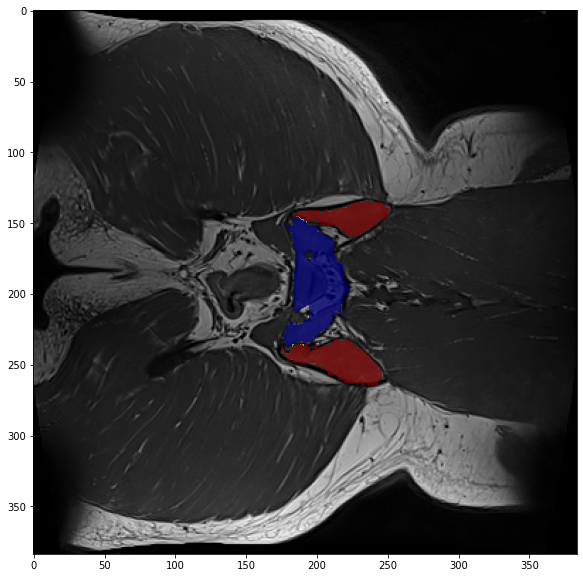

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p.plot_img_mask_on_ax(ax, vol[..., 150], seg3d[..., 150])

In [13]:
def get_markers_nd(segl, label_slices, selem, margin=.05):
    markers = np.zeros_like(segl).astype(int)
    markers[:, label_slices, ...] = -1
    dil_segl = morp.dilation(segl, selem).astype(int) - segl.astype(int)
    markers[dil_segl == 1] = 0
    markers[segl == 1] = 1
    return markers

def get_markers_2d(segl, label_slices, margin=.05):
    return get_markers_nd(segl, label_slices, selem=morp.disk(
        max(margin * segl.shape[0], 1)))

def get_markers_3d(segl, label_slices, margin=.05):
    return get_markers_nd(segl, label_slices, selem=morp.ball(
        max(margin * segl.shape[0], 1)))

def apply_watershed(img, segl, label_slices, margin=.02):
    
    markers = get_markers_nd(segl, label_slices, margin)
    grad_img = np.abs(du.grad_img(img))
    return morp.watershed(grad_img, markers)

# Wrapping

<AxesSubplot:title={'center':'True Segm'}>

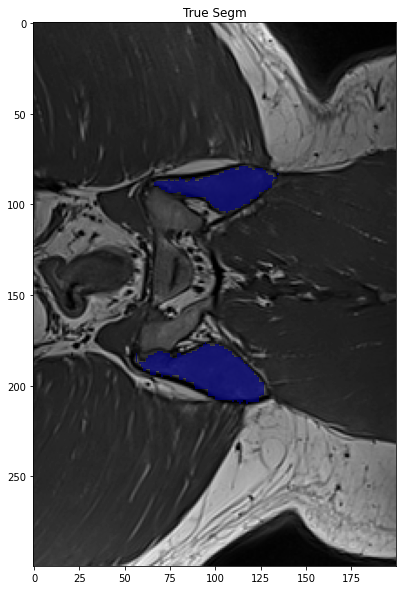

In [7]:
reload_modules()

slice_idx = 150
img = vol[..., slice_idx]
# seg = morp.label(seg3d[..., slice_idx] == 2) == 1
seg = seg3d[..., slice_idx] == 2

img = du.center_and_crop(img, seg, (300, 200))
seg = du.center_and_crop(seg, seg, (300, 200))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title('True Segm')
p.plot_img_mask_on_ax(ax, img, seg)

In [28]:
n_slices = 7
margin = .1 * img.shape[0]

all_slices = np.where(seg.sum(0))[0]
# label_slices = random.sample(list(all_slices), n_slices)
label_slices = np.linspace(all_slices.min() + 1, all_slices.max() - 1, n_slices).astype(int)
segl = np.zeros_like(seg)
segl[:, label_slices] = seg[:, label_slices]
# segl[:, np.array(label_slices) + 1] = seg[:, np.array(label_slices) + 1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
p.plot_img_mask_on_ax(ax, img, segl)

NameError: name 'img' is not defined

<AxesSubplot:>

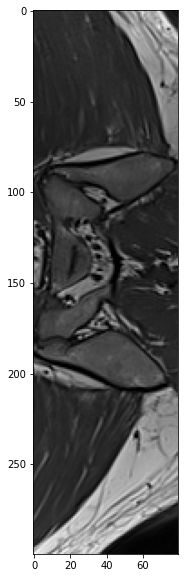

In [54]:
markers = get_markers_2d(segl, label_slices, 0.01)
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
p.plot_img_mask_on_ax(ax, img[:, all_slices], markers[:, all_slices])

In [59]:
reload_modules()
# grad_img = np.abs(du.grad_img(img))
# labels = morp.watershed(grad_img, markers)
labels = apply_watershed(img, segl, label_slices)

IndexError: tuple index out of range

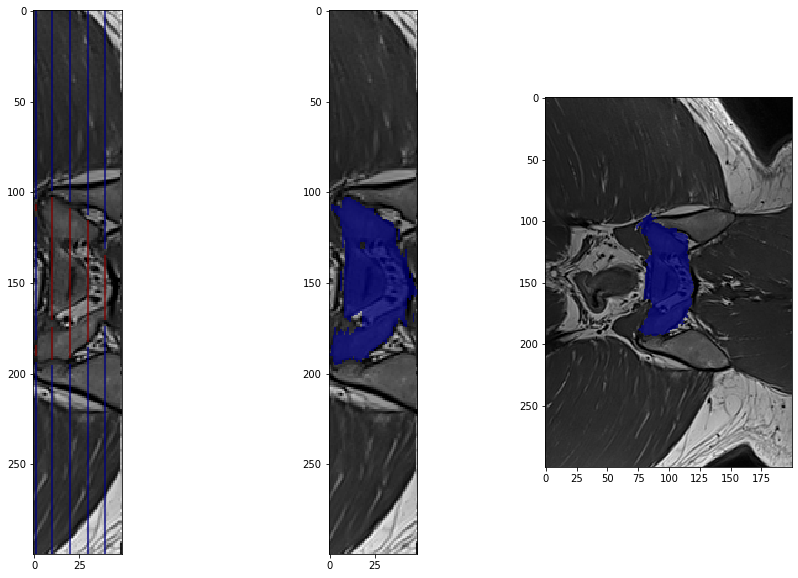

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
p.plot_img_mask_on_ax(axs[0], img[:, all_slices], markers[:, all_slices])
p.plot_img_mask_on_ax(axs[1], img[:, all_slices], seg[:, all_slices])
p.plot_img_mask_on_ax(axs[2], img, labels == 1)

### 3d

In [8]:
cvol = vol[100:300, 150:270]
cseg3d = seg3d[100:300, 150:270]

In [9]:
n_slices = 4
margin = .1 * cvol.shape[0]
cseg = cseg3d == 2

all_slices = np.where(cseg.sum(0).sum(1))[0]

label_slices = np.linspace(all_slices.min() + 1, all_slices.max() - 1, n_slices).astype(int)
csegl = np.zeros_like(cseg)
csegl[:, label_slices, :] = cseg[:, label_slices, :]

<AxesSubplot:>

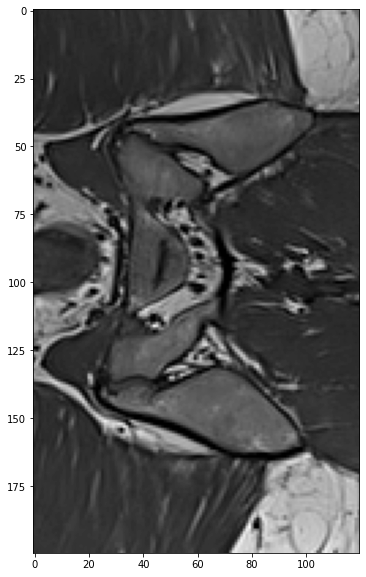

In [10]:
slice_idx = 150
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
p.plot_img_mask_on_ax(ax, cvol[..., slice_idx], csegl[..., slice_idx])

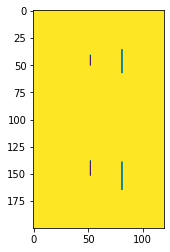

In [11]:
mask = csegl[..., slice_idx]
masked = np.ma.masked_where(mask == 0, mask)
plt.imshow(masked.mask)

In [14]:
markers = get_markers_3d(csegl, label_slices, margin=0)

<AxesSubplot:>

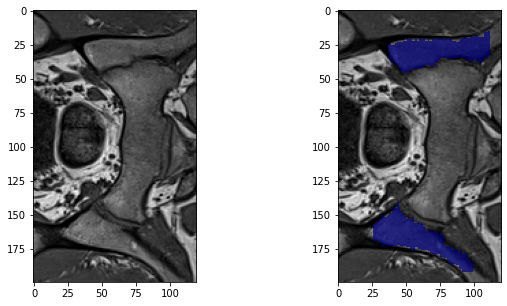

In [15]:
slice_z = 110
slice_y = 104

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
p.plot_img_mask_on_ax(axs[0], cvol[..., slice_z], markers[..., slice_z])
# p.plot_img_mask_on_ax(axs[1], cvol[:, slice_y, :], cseg[:, slice_y, :])
p.plot_img_mask_on_ax(axs[1], cvol[..., slice_z], cseg[..., slice_z])

In [16]:
grad_vol = du.grad_morp(cvol, morp.ball(1))

In [17]:
%%time
labels = morp.watershed(grad_vol, markers)

/media/theodore/HDD1/python_venv/torchenv/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


CPU times: user 5.28 s, sys: 29.7 ms, total: 5.31 s
Wall time: 5.62 s


<AxesSubplot:>

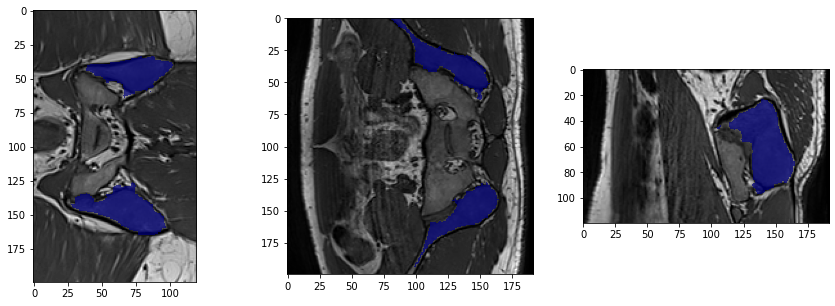

In [18]:
slice_x, slice_y, slice_z = 147, 66, 150

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
p.plot_img_mask_on_ax(axs[0], cvol[..., slice_z], labels[..., slice_z] == 1)
p.plot_img_mask_on_ax(axs[1], cvol[:, slice_y, :], labels[:, slice_y, :] == 1)
p.plot_img_mask_on_ax(axs[2], cvol[slice_x, ...], labels[slice_x, ...] == 1)

In [20]:
np.save("./test_segm.npy", labels )

In [33]:
final_pred = np.zeros_like(vol)
final_pred[100:300, 150:270] = labels
final_pred[final_pred == -1] = 0
np.save("./final_pred.npy", final_pred)

In [38]:
final_pred_nii = convert_to_nii(final_pred, vol_nib.affine)
nib.save(final_pred_nii, 'final_pred.nii.gz')

In [82]:
label_slices

array([ 24,  52,  81, 110])

In [84]:
import time

import vpython as visual
import numpy as np
import skimage.morphology as morp

from src.geometry.utils import get_barycenter_nonzero_3d

# segm = np.load('./true_seg.npy') == 2
# segm = labels == 
segm = cseg + 0
# segm = np.load('./test_segm.npy')
W, L, H = segm.shape

segm = (
    segm -
    morp.binary_erosion(segm, morp.ball(1)).astype(int)
)

bary = get_barycenter_nonzero_3d(segm)



def show_segm():
    for i in range(W):
        for j in range(L):
            for k in range(H):
                if segm[i, j, k]:
                    voxel=vp.box(
                        pos=vp.vector(i,j,k) - vp.vector(*bary),radius=1,
                        color=vp.color.green)
start = time.time()
sc1 = an.draw(show_segm)

print('Duration:', time.time() - start)


In [47]:
segm.sum()

34310

In [24]:
morp.ball(1)

array([[[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
sc2.delete()

In [22]:
labels.sum()

-4247324

In [23]:
def create_triangle():
    v1 = vp.vertex(pos=vp.vec(0,0,0), color=vp.color.cyan)
    v2 = vp.vertex(pos=vp.vec(0,1,0), color=vp.color.cyan)
    v3 = vp.vertex(pos=vp.vec(1,0,0), color=vp.color.cyan)

    return vp.triangle(vs=[v1, v2, v3])
    
sc1 = an.draw(create_vertex)

<IPython.core.display.Javascript object>